# Imports

In [1]:
import shap
import optuna

import numpy   as np
import pandas  as pd
import seaborn as sns
import category_encoders as ce

import matplotlib.pyplot as plt

from mrmr import mrmr_regression

from xgboost  import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from feature_engine import encoding
from feature_engine import creation
from feature_engine import imputation

from sklearn.metrics           import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection   import cross_validate
from sklearn.feature_selection import SelectFromModel

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Functions

In [2]:
random_state = 42
np.random.seed(random_state)

In [3]:
def jupyter_settings():
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 500

jupyter_settings()

In [4]:
def get_cross_validate_metrics(dict_cv_result):

    print(f"""
    R2 test mean: {dict_cv_result['test_r2'].mean()}; 
    R2 test std: {dict_cv_result['test_r2'].std()}

    MAE test mean: {dict_cv_result['test_mae'].mean()}; 
    MAE test std: {dict_cv_result['test_mae'].std()}
    
    RMSE test mean: {dict_cv_result['test_rmse'].mean()}; 
    RMSE test std: {dict_cv_result['test_rmse'].std()}
    """)

In [5]:
def get_metrics(y_true, y_pred):

    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"R2: {r2}; RMSE: {rmse}; MAE: {mae}; MAPE: {mape}")

In [6]:
def do_hyperparameter_tuning(estimator, optuna_params, X, y, n_trials, scoring, random_state=42, cv=3, n_jobs=-1):

    optuna_search = optuna.integration.OptunaSearchCV(
        estimator=estimator, 
        param_distributions=optuna_params, 
        cv=cv, 
        n_jobs=n_jobs, 
        n_trials=n_trials, 
        scoring=scoring,
        random_state=random_state,
        verbose=0)

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    optuna_search.fit(X, y)

    return optuna_search, optuna_search.best_params_, optuna_search.best_score_

# Loading Datasets

In [7]:
df_train = pd.read_parquet('../data/processed/df_train_from_2.2_exploratory_data_analysis.parquet')
df_oot = pd.read_parquet('../data/processed/df_oot_from_2.2_exploratory_data_analysis.parquet')

## Columns

In [8]:
df_train.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

In [9]:
df_oot.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

## Data Dimensions

In [10]:
print('Number of Rows: {}'.format(df_train.shape[0]))
print('Number of Cols: {}'.format(df_train.shape[1]))

Number of Rows: 77853
Number of Cols: 147


In [11]:
print('Number of Rows: {}'.format(df_oot.shape[0]))
print('Number of Cols: {}'.format(df_oot.shape[1]))

Number of Rows: 18603
Number of Cols: 147


## Data Types

In [12]:
df_train.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

In [13]:
df_oot.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

## Check NA

In [14]:
df_train.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002697
customer_lng                                0.002697
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.002440
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.002453
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.005112
distance_customer_seller_max                0.

In [15]:
df_oot.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002903
customer_lng                                0.002903
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.001398
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.001398
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.004193
distance_customer_seller_max                0.

## Splitting into X and y

In [16]:
list_columns = [
    'order_purchase_timestamp', 'order_delivered_customer_date', 
    'order_estimated_delivery_date', 'delivered_in_days', 'estimated_delivery_in_days', 'time']

X_train = df_train.drop(columns=list_columns)
X_oot = df_oot.drop(columns=list_columns)

In [17]:
target = 'delivered_in_days'
list_columns = ['delivered_in_days', 'estimated_delivery_in_days']

y_train = df_train.loc[:, list_columns]
y_oot = df_oot.loc[:, list_columns]

# Feature Engineering

## Fill NA

In [18]:
categorical_variables = X_train.select_dtypes(include='object').columns.tolist()

In [19]:
cat_imputer = imputation.CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=categorical_variables)
X_train = cat_imputer.fit_transform(X_train)
X_oot = cat_imputer.transform(X_oot)

## Categorical Encoding

In [20]:
rare_label_encoder = encoding.RareLabelEncoder(variables=categorical_variables)

X_train = rare_label_encoder.fit_transform(X_train)
X_oot = rare_label_encoder.transform(X_oot)

In [21]:
count_encoder = ce.CountEncoder(
    cols=None, return_df=True, handle_unknown='value', 
    handle_missing='value', normalize=True)

X_train[[c + '_ce' for c in categorical_variables]] = count_encoder.fit_transform(X_train[categorical_variables])
X_oot[[c + '_ce' for c in categorical_variables]] = count_encoder.transform(X_oot[categorical_variables])

In [22]:
target_encoder = ce.TargetEncoder(
    cols=None, return_df=False, handle_missing='value', handle_unknown='value')

X_train[[c + '_te' for c in categorical_variables]] = target_encoder.fit_transform(X_train[categorical_variables], y_train[target])
X_oot[[c + '_te' for c in categorical_variables]] = target_encoder.transform(X_oot[categorical_variables])

## Removing Features

In [23]:
categorical_columns = X_train.select_dtypes(include='object').columns.tolist()

X_train = X_train.drop(columns=categorical_columns)
X_oot = X_oot.drop(columns=categorical_columns)

In [24]:
list_selected_features_rmrm = mrmr_regression(X=X_train, y=y_train[target], K=50)

100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.29it/s]


# Machine Learning Modeling

## LightGBM Regressor

### First Hyperparameter Tuning

In [25]:
%%time

optuna_params = {
    "n_estimators": optuna.distributions.IntDistribution(100, 1100, 100),
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
    "num_leaves": optuna.distributions.IntDistribution(2, 2**10),
    "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
    "colsample_bytree": optuna.distributions.FloatDistribution(0.05, 1.0),
    "min_data_in_leaf": optuna.distributions.IntDistribution(1, 100)}

model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    verbosity=-1,
    bagging_freq=1,
    random_state=random_state)

optuna_search, best_params, best_score = do_hyperparameter_tuning(
    estimator=model, optuna_params=optuna_params, X=X_train[list_selected_features_rmrm], y=y_train[target], 
    n_trials=50, scoring='neg_root_mean_squared_error')

print('Best hyperparameters:', best_params)
print('Best RMSE:', best_score)

Best hyperparameters: {'n_estimators': 822, 'learning_rate': 0.007526545206723499, 'num_leaves': 398, 'subsample': 0.8869977383700052, 'colsample_bytree': 0.751306293985334, 'min_data_in_leaf': 90}
Best RMSE: -8.280668143544865
CPU times: user 2h 16min 16s, sys: 1h 42min 7s, total: 3h 58min 24s
Wall time: 20min 29s


In [26]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'random_state': random_state,
    'n_estimators': 822, 
    'learning_rate': 0.007526545206723499, 
    'num_leaves': 398, 
    'subsample': 0.8869977383700052, 
    'colsample_bytree': 0.751306293985334, 
    'min_data_in_leaf': 90}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features_rmrm], y_train[target])

y_oot['pred'] = lgbm.predict(X_oot[list_selected_features_rmrm])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.0026132345779172894; RMSE: 5.799371452268501; MAE: 4.344924238306878; MAPE: 113268398984950.47


### Feature Selection

In [27]:
sfm = SelectFromModel(estimator=LGBMRegressor(**params, n_jobs=-1))
sfm.fit(X_train[list_selected_features_rmrm], y_train[target])

list_selected_features = X_train[list_selected_features_rmrm].loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['distance_customer_seller_min',
 'product_height_cm_min',
 'distance_customer_seller_q25',
 'freight_value_min',
 'customer_lat',
 'order_approved_at_second',
 'customer_lng',
 'order_purchase_timestamp_month',
 'product_length_cm_min',
 'product_weight_g_min',
 'payment_value_q75',
 'payment_value_max',
 'payment_value_mean',
 'order_approved_at_month']

In [28]:
lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target])

y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.0020993983196997412; RMSE: 5.8008651274041325; MAE: 4.362677851161491; MAPE: 116178507117763.14


### Second Hyperparamenter Tuning

In [29]:
%%time

optuna_params = {
    "n_estimators": optuna.distributions.IntDistribution(100, 1100, 100),
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
    "num_leaves": optuna.distributions.IntDistribution(2, 2**10),
    "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
    "colsample_bytree": optuna.distributions.FloatDistribution(0.05, 1.0),
    "min_data_in_leaf": optuna.distributions.IntDistribution(1, 100)}

model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    verbosity=-1,
    bagging_freq=1,
    random_state=random_state)

optuna_search, best_params, best_score = do_hyperparameter_tuning(
    estimator=model, optuna_params=optuna_params, X=X_train[list_selected_features], y=y_train[target], 
    n_trials=50, scoring='neg_root_mean_squared_error')

print('Best hyperparameters:', best_params)
print('Best RMSE:', best_score)

Best hyperparameters: {'n_estimators': 832, 'learning_rate': 0.006365688565352602, 'num_leaves': 867, 'subsample': 0.6922606184521125, 'colsample_bytree': 0.4826899205085819, 'min_data_in_leaf': 52}
Best RMSE: -8.347833620063584
CPU times: user 1h 28min 4s, sys: 1h 35min 13s, total: 3h 3min 17s
Wall time: 15min 52s


In [30]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'random_state': random_state,
    'n_estimators': 832, 
    'learning_rate': 0.006365688565352602, 
    'num_leaves': 867, 
    'subsample': 0.6922606184521125, 
    'colsample_bytree': 0.4826899205085819, 
    'min_data_in_leaf': 52}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target])

y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.010447901186684594; RMSE: 5.776548950980762; MAE: 4.355468761199317; MAPE: 114987946674777.47


## CatBoost Regressor

### First Hyperparameter Tuning

In [31]:
%%time

optuna_params = {
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
    "depth": optuna.distributions.IntDistribution(1, 10),
    "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
    "colsample_bylevel": optuna.distributions.FloatDistribution(0.05, 1.0),
    "min_data_in_leaf": optuna.distributions.IntDistribution(1, 100)}

model = CatBoostRegressor(iterations=1000, silent=True)

optuna_search, best_params, best_score = do_hyperparameter_tuning(
    estimator=model, optuna_params=optuna_params, X=X_train[list_selected_features_rmrm], y=y_train[target], 
    n_trials=30, scoring='neg_root_mean_squared_error')

print('Best hyperparameters:', best_params)
print('Best RMSE:', best_score)

Best hyperparameters: {'learning_rate': 0.08374202280389698, 'depth': 7, 'subsample': 0.7865950777565244, 'colsample_bylevel': 0.9839210071096465, 'min_data_in_leaf': 46}
Best RMSE: -8.333005355595718
CPU times: user 1h 3min 22s, sys: 6min 43s, total: 1h 10min 6s
Wall time: 6min 25s


In [32]:
params = {
    'iterations': 1000,
    'silent': True,
    'learning_rate': 0.08374202280389698, 
    'depth': 7, 
    'subsample': 0.7865950777565244, 
    'colsample_bylevel': 0.9839210071096465, 
    'min_data_in_leaf': 46}

cat = CatBoostRegressor(**params)
cat.fit(X_train[list_selected_features_rmrm], y_train[target])

y_oot['pred'] = cat.predict(X_oot[list_selected_features_rmrm])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.019995096284408875; RMSE: 5.748615350088194; MAE: 4.278364120587111; MAPE: 113824074696453.94


### Feature Selection

In [33]:
sfm = SelectFromModel(estimator=CatBoostRegressor(**params))
sfm.fit(X_train[list_selected_features_rmrm], y_train[target])

list_selected_features = X_train[list_selected_features_rmrm].loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['distance_customer_seller_min',
 'product_height_cm_min',
 'customer_state_te',
 'distance_customer_seller_q25',
 'distance_customer_seller_mean',
 'customer_lat',
 'order_approved_at_second',
 'customer_lng',
 'order_purchase_timestamp_month',
 'product_category_name_mode_te',
 'payment_value_max',
 'seller_geolocation_state_mode_te',
 'order_approved_at_month']

In [34]:
cat = CatBoostRegressor(**params)
cat.fit(X_train[list_selected_features], y_train[target])

y_oot['pred'] = cat.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.047522830583612174; RMSE: 5.667302745001682; MAE: 4.199539157559659; MAPE: 117153817473170.03


### Second Hyperparameter Tuning

In [37]:
%%time

optuna_params = {
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
    "depth": optuna.distributions.IntDistribution(1, 10),
    "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
    "colsample_bylevel": optuna.distributions.FloatDistribution(0.05, 1.0),
    "min_data_in_leaf": optuna.distributions.IntDistribution(1, 100)}

model = CatBoostRegressor(iterations=1000, silent=True)

optuna_search, best_params, best_score = do_hyperparameter_tuning(
    estimator=model, optuna_params=optuna_params, X=X_train[list_selected_features], y=y_train[target], 
    n_trials=60, scoring='neg_root_mean_squared_error')

print('Best hyperparameters:', best_params)
print('Best RMSE:', best_score)

Best hyperparameters: {'learning_rate': 0.02821255798024686, 'depth': 10, 'subsample': 0.548651202921136, 'colsample_bylevel': 0.8268138709767985, 'min_data_in_leaf': 80}
Best RMSE: -8.4046036625697
CPU times: user 1h 26min 29s, sys: 7min 40s, total: 1h 34min 9s
Wall time: 8min 41s


In [39]:
params = {
    'iterations': 1000,
    'silent': True,
    'learning_rate': 0.02821255798024686, 
    'depth': 10, 
    'subsample': 0.548651202921136, 
    'colsample_bylevel': 0.8268138709767985, 
    'min_data_in_leaf': 80}

cat = CatBoostRegressor(**params)
cat.fit(X_train[list_selected_features], y_train[target])

y_oot['pred'] = cat.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.06492877833934552; RMSE: 5.615280705701383; MAE: 4.180621132214562; MAPE: 118100944272400.11


## XGBoost Regressor

### First Hyperparameter Tuning

In [40]:
%%time

optuna_params = {
    "n_estimators": optuna.distributions.IntDistribution(100, 1100, 100),
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
    "max_depth": optuna.distributions.IntDistribution(1, 10),
    "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
    "colsample_bytree": optuna.distributions.FloatDistribution(0.05, 1.0),
    "min_child_weight": optuna.distributions.IntDistribution(1, 20)}

model = XGBRegressor()

optuna_search, best_params, best_score = do_hyperparameter_tuning(
    estimator=model, optuna_params=optuna_params, X=X_train[list_selected_features_rmrm], y=y_train[target], 
    n_trials=50, scoring='neg_root_mean_squared_error')

print('Best hyperparameters:', best_params)
print('Best RMSE:', best_score)

Best hyperparameters: {'n_estimators': 772, 'learning_rate': 0.019454839256728234, 'max_depth': 9, 'subsample': 0.9266786224098277, 'colsample_bytree': 0.48660772985195444, 'min_child_weight': 18}
Best RMSE: -8.294555396862767
CPU times: user 54min 53s, sys: 7min 31s, total: 1h 2min 25s
Wall time: 5min 35s


In [41]:
params = {
    'n_estimators': 772, 
    'learning_rate': 0.019454839256728234, 
    'max_depth': 9, 
    'subsample': 0.9266786224098277, 
    'colsample_bytree': 0.48660772985195444, 
    'min_child_weight': 18}

xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features_rmrm], y_train[target], verbose=False)

y_oot['pred'] = xgb.predict(X_oot[list_selected_features_rmrm])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.014143750536703026; RMSE: 5.765751527478779; MAE: 4.318656999853512; MAPE: 113332018156029.28


### Feature Selecion

In [42]:
sfm = SelectFromModel(estimator=XGBRegressor(**params))
sfm.fit(X_train[list_selected_features_rmrm], y_train[target])

list_selected_features = X_train[list_selected_features_rmrm].loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['distance_customer_seller_min',
 'customer_state_te',
 'distance_customer_seller_q25',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'customer_state_ce',
 'order_purchase_timestamp_month',
 'order_approved_at_month']

In [43]:
xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features], y_train[target], verbose=False)

y_oot['pred'] = xgb.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.008722905763847377; RMSE: 5.781581622698788; MAE: 4.349481712622853; MAPE: 124395270835757.44


### Second Hyperparameter Tuning

In [44]:
%%time

optuna_params = {
    "n_estimators": optuna.distributions.IntDistribution(100, 1100, 100),
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
    "max_depth": optuna.distributions.IntDistribution(1, 10),
    "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
    "colsample_bytree": optuna.distributions.FloatDistribution(0.05, 1.0),
    "min_child_weight": optuna.distributions.IntDistribution(1, 20)}

model = XGBRegressor()

optuna_search, best_params, best_score = do_hyperparameter_tuning(
    estimator=model, optuna_params=optuna_params, X=X_train[list_selected_features], y=y_train[target], 
    n_trials=100, scoring='neg_root_mean_squared_error')

print('Best hyperparameters:', best_params)
print('Best RMSE:', best_score)

Best hyperparameters: {'n_estimators': 138, 'learning_rate': 0.04847311427418716, 'max_depth': 5, 'subsample': 0.9073680196367773, 'colsample_bytree': 0.8874178660243036, 'min_child_weight': 18}
Best RMSE: -8.589999200841264
CPU times: user 10min 1s, sys: 3min 38s, total: 13min 39s
Wall time: 1min 14s


In [45]:
params = {
    'n_estimators': 138, 
    'learning_rate': 0.04847311427418716, 
    'max_depth': 5, 
    'subsample': 0.9073680196367773, 
    'colsample_bytree': 0.8874178660243036, 
    'min_child_weight': 18}

xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features], y_train[target])

y_oot['pred'] = xgb.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.042066525120223464; RMSE: 5.683512254822177; MAE: 4.304641758338909; MAPE: 127301528749415.61


# Result Analysis

## Final Model

In [25]:
list_selected_features = [
    'distance_customer_seller_min',
    'product_height_cm_min',
    'distance_customer_seller_q25',
    'freight_value_min',
    'customer_lat',
    'order_approved_at_second',
    'customer_lng',
    'order_purchase_timestamp_month',
    'product_length_cm_min',
    'product_weight_g_min',
    'payment_value_q75',
    'payment_value_max',
    'payment_value_mean',
    'order_approved_at_month']

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'random_state': random_state,
    'n_estimators': 832, 
    'learning_rate': 0.006365688565352602, 
    'num_leaves': 867, 
    'subsample': 0.6922606184521125, 
    'colsample_bytree': 0.4826899205085819, 
    'min_data_in_leaf': 52}

dict_cv_results = cross_validate(
    LGBMRegressor(**params), X=X_train[list_selected_features], y=y_train[target], 
    scoring={'r2': 'r2', 'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, 
    cv=3, n_jobs=-1)

get_cross_validate_metrics(dict_cv_results)


    R2 test mean: 0.3008610346273051; 
    R2 test std: 0.005168349210662973

    MAE test mean: -5.123517471052414; 
    MAE test std: 0.030781855582665323
    
    RMSE test mean: -8.347833620063584; 
    RMSE test std: 0.19346030702225256
    


In [26]:
model = LGBMRegressor(**params)
model.fit(X_train[list_selected_features], y_train[target])

y_train['pred'] = model.predict(X_train[list_selected_features])

y_oot['pred'] = model.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.010447901186684594; RMSE: 5.776548950980762; MAE: 4.355468761199317; MAPE: 114987946674777.47


### Feature Importances

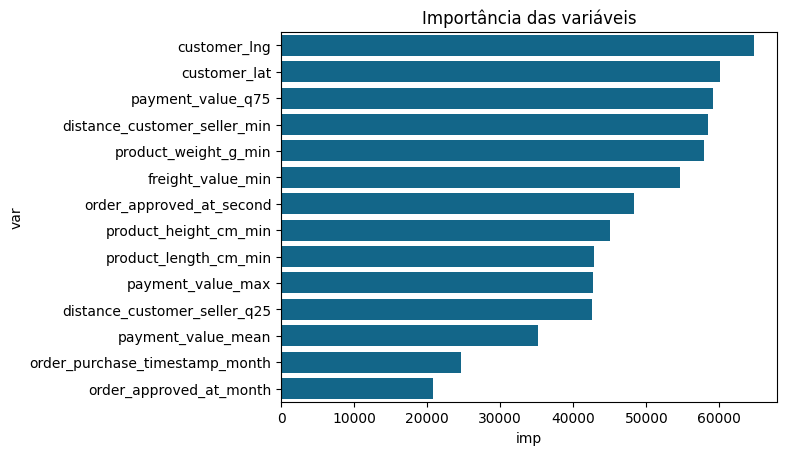

In [27]:
imp = pd.DataFrame(model.feature_importances_, X_train[list_selected_features].columns).reset_index()
imp.columns = ["var", "imp"]
imp = imp.sort_values("imp", ascending=False)

sns.barplot(x="imp", y="var", color="#006e9cff", data=imp.iloc[:30])

plt.title(f"Importância das variáveis")
plt.show()

### Shap Values

In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train[list_selected_features])

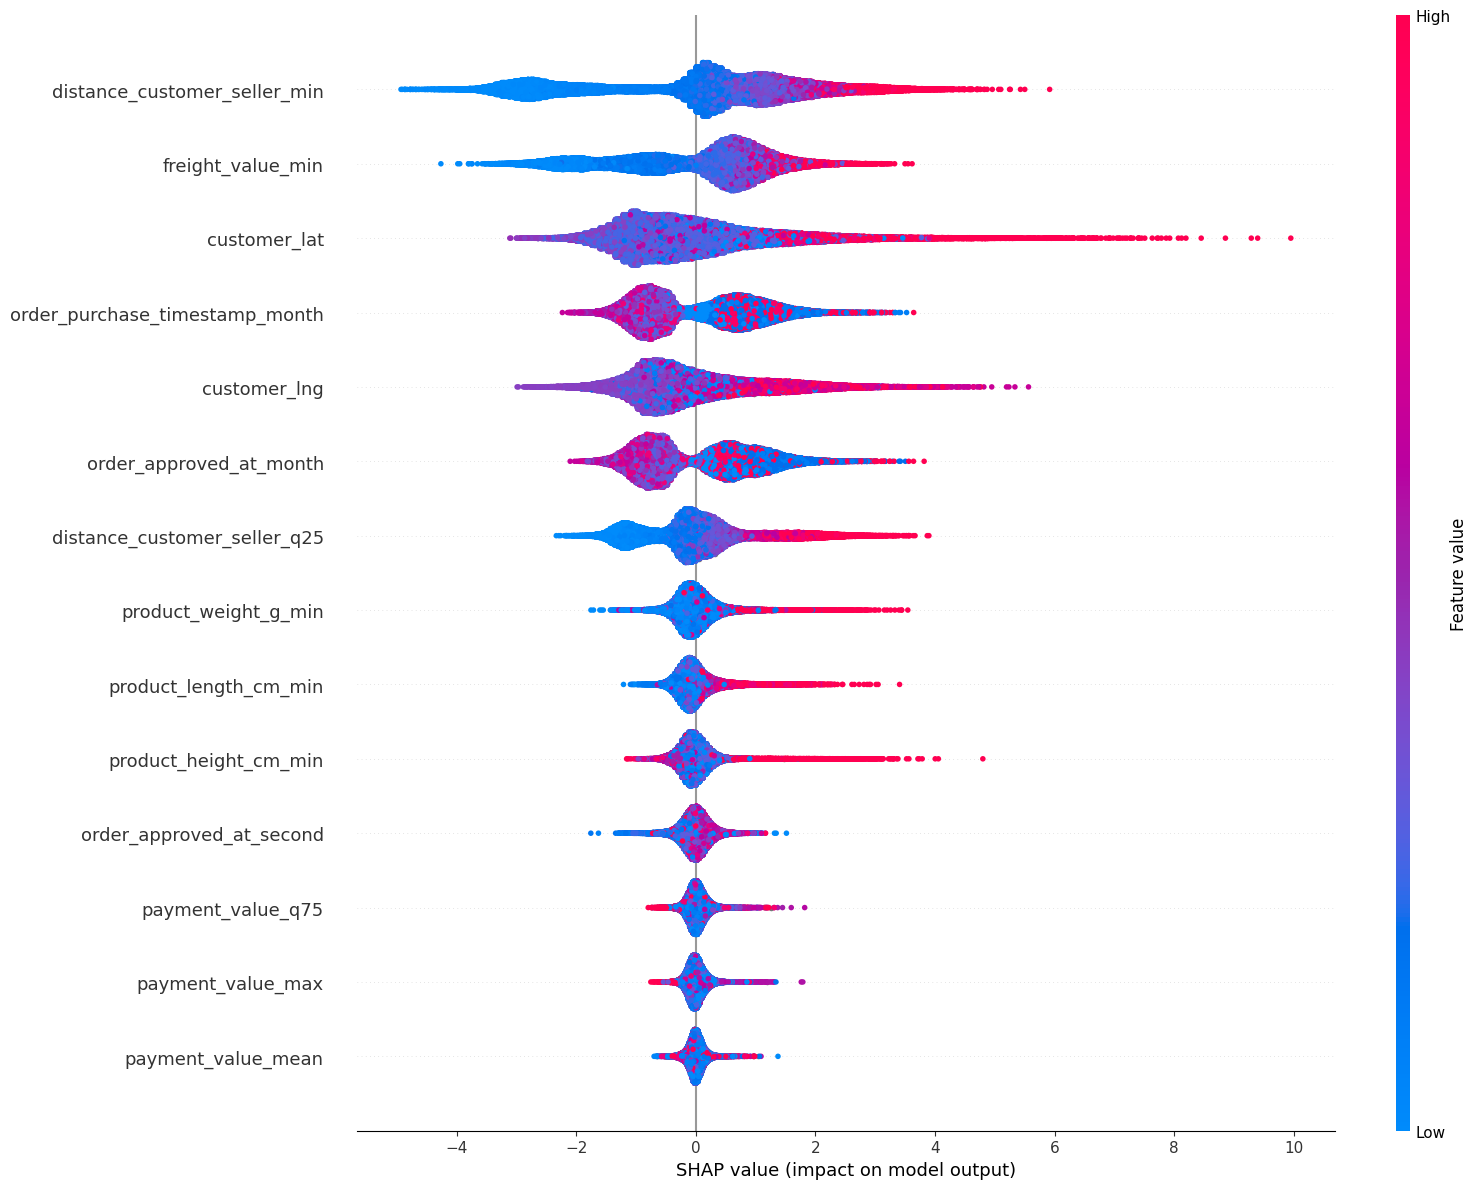

,index,impact
0,distance_customer_seller_min,1.391511
3,freight_value_min,0.988978
4,customer_lat,0.952571
7,order_purchase_timestamp_month,0.827570
6,customer_lng,0.816531
13,order_approved_at_month,0.809360
2,distance_customer_seller_q25,0.644501
9,product_weight_g_min,0.247320
8,product_length_cm_min,0.231069
1,product_height_cm_min,0.209408


In [29]:
shap.summary_plot(shap_values, X_train[list_selected_features], plot_size=(16, 12))

shap_df = pd.DataFrame(np.abs(shap_values), columns=list_selected_features)
shap_df = (
    pd.DataFrame(shap_df.mean(), columns=["impact"]).reset_index()
    .rename(columns={"level_0": "var"})
    .sort_values(by=["impact"], ascending=False))

display(shap_df)

## Analysis of Estimated Values

### Train Values

In [30]:
get_metrics(y_train[target], y_train['estimated_delivery_in_days'])

R2: -1.2810417739559368; RMSE: 15.080866883305696; MAE: 12.761871732624305; MAPE: 62012495350742.0


In [31]:
get_metrics(y_train[target], y_train['pred'])

R2: 0.5176931162581914; RMSE: 6.934600032978889; MAE: 4.136388629059644; MAPE: 18578686607514.883


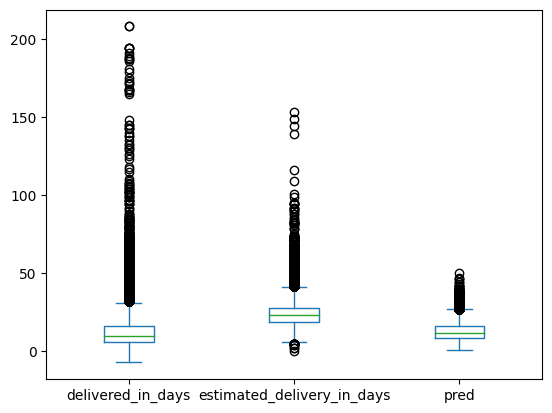

In [32]:
y_train.plot(kind='box');

### OoT Values

In [33]:
get_metrics(y_oot[target], y_oot['estimated_delivery_in_days'])

R2: -6.096547120243494; RMSE: 15.469371569468713; MAE: 12.755738321776057; MAPE: 243542505248334.34


In [34]:
get_metrics(y_oot[target], y_oot['pred'])

R2: 0.010447901186684594; RMSE: 5.776548950980762; MAE: 4.355468761199317; MAPE: 114987946674777.47


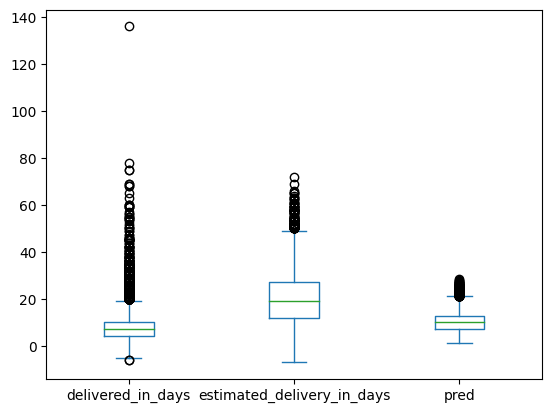

In [35]:
y_oot.plot(kind='box');

### Metrics over Time

In [36]:
df_aux = pd.concat([df_train[['time']], df_oot[['time']]], axis=0)
df_aux1 = pd.concat([y_train, y_oot], axis=0)

df_aux = pd.concat([df_aux, df_aux1], axis=1)

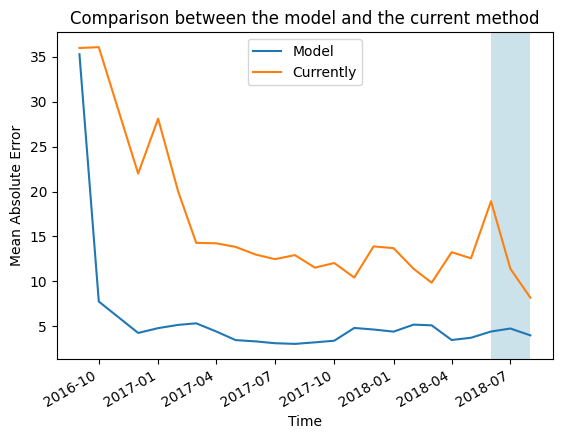

In [37]:
df_aux.groupby('time').apply(lambda i: mean_absolute_error(i[target], i['pred'])).plot(label='Model')
df_aux.groupby('time').apply(lambda i: mean_absolute_error(i[target], i['estimated_delivery_in_days'])).plot(label='Currently')

plt.axvspan("2018-06-01", "2018-08-01", facecolor="#006e9cff", alpha=0.2)

plt.title('Comparison between the model and the current method')
plt.xlabel('Time')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best');

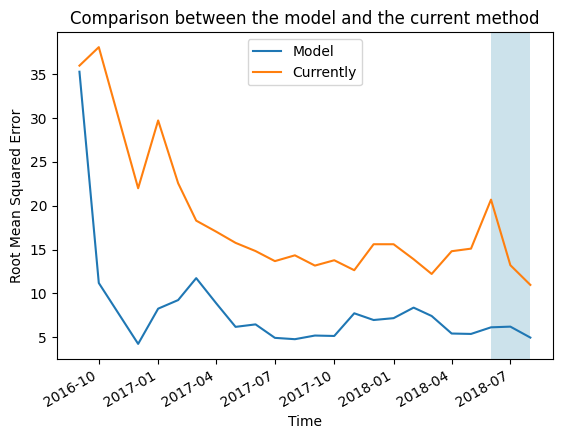

In [38]:
df_aux.groupby('time').apply(lambda i: mean_squared_error(i[target], i['pred'], squared=False)).plot(label='Model')
df_aux.groupby('time').apply(lambda i: mean_squared_error(i[target], i['estimated_delivery_in_days'], squared=False)).plot(label='Currently')

plt.axvspan("2018-06-01", "2018-08-01", facecolor="#006e9cff", alpha=0.2)

plt.title('Comparison between the model and the current method')
plt.xlabel('Time')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='best');